In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

print("TF Version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2025-11-30 06:13:08.432654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764483188.850719      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764483188.997742      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF Version: 2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
def load_dataset(video_dir, label, frames_per_clip=10):
    data, labels = [], []

    for video_name in sorted(os.listdir(video_dir)):
        video_path = os.path.join(video_dir, video_name)
        if not video_path.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            continue

        cap = cv2.VideoCapture(video_path)
        frames = []
        success = True

        while success and len(frames) < frames_per_clip:
            success, frame = cap.read()
            if success:
                frame = cv2.resize(frame, (64, 64))
                frame = frame / 255.0
                frames.append(frame)

        cap.release()

        if len(frames) == frames_per_clip:
            data.append(frames)
            labels.append(label)

    print("Loaded:", video_dir, "Count:", len(data))
    return np.array(data), np.array(labels)


In [3]:
violence_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence'
non_violence_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence'

violence_data, violence_labels = load_dataset(violence_path, 1)
non_violence_data, non_violence_labels = load_dataset(non_violence_path, 0)

X = np.concatenate((violence_data, non_violence_data), axis=0)
y = np.concatenate((violence_labels, non_violence_labels), axis=0)

y = to_categorical(y, num_classes=2)

print("Dataset shape:", X.shape, y.shape)


Loaded: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence Count: 1000
Loaded: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence Count: 1000
Dataset shape: (2000, 10, 64, 64, 3) (2000, 2)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1600, 10, 64, 64, 3) Test: (400, 10, 64, 64, 3)


In [5]:
from tensorflow.keras.layers import Dropout

frames_per_clip = 10
height, width = 64, 64

model = Sequential([
    TimeDistributed(
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        input_shape=(frames_per_clip, height, width, 3)
    ),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(
        Conv2D(64, (3, 3), activation='relu', padding='same')
    ),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(
        Conv2D(128, (3, 3), activation='relu', padding='same')
    ),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),

    Dense(64, activation='relu'),
    Dropout(0.5),

    # 2 classes: [non-violent, violent]
    Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1764483284.459486      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764483284.460164      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 16, 16,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     4,260,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,361,986 (16.64 MB)

 Trainable params: 4,361,986 (16.64 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

checkpoint_path = "best_violence_model.h5"

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    epochs=30,          # let callbacks stop earlier if needed
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Save final model (after EarlyStopping restored best weights)
model.save("violence_model.h5")
print("Saved violence_model.h5")


Epoch 1/30


I0000 00:00:1764483300.601979    8112 cuda_dnn.cc:529] Loaded cuDNN version 90300


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4966 - loss: 0.7067
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.4968 - loss: 0.7066 - val_accuracy: 0.5375 - val_loss: 0.6771 - learning_rate: 1.0000e-04
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5790 - loss: 0.6616
Epoch 2: val_accuracy improved from 0.53750 to 0.71000, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5791 - loss: 0.6615 - val_accuracy: 0.7100 - val_loss: 0.6234 - learning_rate: 1.0000e-04
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6864 - loss: 0.5971
Epoch 3: val_accuracy improved from 0.71000 to 0.71750, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6865 - loss: 0.5971 - val_accuracy: 0.7175 - val_loss: 0.5600 - learning_rate: 1.0000e-04
Epoch 4/30
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7551 - loss: 0.5261
Epoch 4: val_accuracy improved from 0.71750 to 0.75250, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7551 - loss: 0.5260 - val_accuracy: 0.7525 - val_loss: 0.5031 - learning_rate: 1.0000e-04
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7953 - loss: 0.4302
Epoch 5: val_accuracy improved from 0.75250 to 0.77000, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7953 - loss: 0.4302 - val_accuracy: 0.7700 - val_loss: 0.4654 - learning_rate: 1.0000e-04
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8245 - loss: 0.4025
Epoch 6: val_accuracy improved from 0.77000 to 0.79250, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8245 - loss: 0.4025 - val_accuracy: 0.7925 - val_loss: 0.4424 - learning_rate: 1.0000e-04
Epoch 7/30
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8477 - loss: 0.3171
Epoch 7: val_accuracy improved from 0.79250 to 0.81000, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8477 - loss: 0.3171 - val_accuracy: 0.8100 - val_loss: 0.4235 - learning_rate: 1.0000e-04
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8777 - loss: 0.3153
Epoch 8: val_accuracy did not improve from 0.81000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8776 - loss: 0.3153 - val_accuracy: 0.7575 - val_loss: 0.4856 - learning_rate: 1.0000e-04
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8971 - loss: 0.2755
Epoch 9: val_accuracy did not improve from 0.81000

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8971 - loss: 0.2755 - val_accuracy: 0.8025 - val_loss: 0.4436 - learning_rate: 1.0000e-04
Epoch 10/30
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9292 - loss: 0.1926
Epoch 10: val_accuracy improved from 0.81000 to 0.81250, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9291 - loss: 0.1926 - val_accuracy: 0.8125 - val_loss: 0.4144 - learning_rate: 5.0000e-05
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9280 - loss: 0.1854
Epoch 11: val_accuracy improved from 0.81250 to 0.83000, saving model to best_violence_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9280 - loss: 0.1853 - val_accuracy: 0.8300 - val_loss: 0.4483 - learning_rate: 5.0000e-05
Epoch 12/30
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9379 - loss: 0.1643
Epoch 12: val_accuracy did not improve from 0.83000

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9379 - loss: 0.1644 - val_accuracy: 0.8100 - val_loss: 0.4704 - learning_rate: 5.0000e-05
Epoch 13/30
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9524 - loss: 0.1349
Epoch 13: val_accuracy did not improve from 0.83000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9524 - loss: 0.1349 - val_accuracy: 0.7850 - val_loss: 0.5661 - learning_rate: 2.5000e-05
Epoch 14/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9487 - loss: 0.1333
Epoch 14: val_accuracy did not improve from 0.83000

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.2499

Saved violence_model.h5


In [7]:
model.save("violence_model.h5")
print("Model saved as violence_model.h5")


Model saved as violence_model.h5


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# ---- Get predictions ----
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ---- Metrics ----
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# ---- Full Classification Report ----
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Non-Violent", "Violent"]))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
Precision: 0.8078817733990148
Recall: 0.82
F1 Score: 0.8138957816377171

Confusion Matrix:
 [[161  39]
 [ 36 164]]

Classification Report:

              precision    recall  f1-score   support

 Non-Violent       0.82      0.81      0.81       200
     Violent       0.81      0.82      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



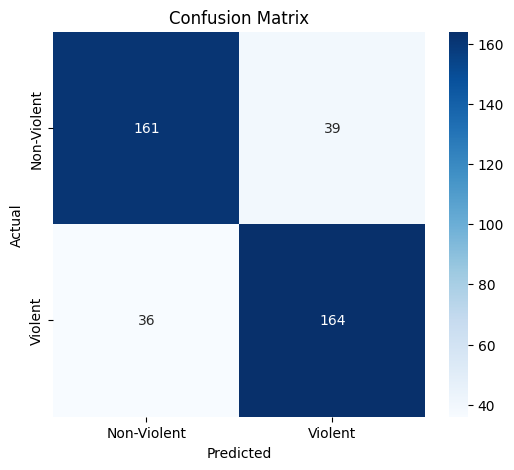

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Violent", "Violent"],
            yticklabels=["Non-Violent", "Violent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
